In [58]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_curve, precision_recall_curve, auc,
    make_scorer, fbeta_score, matthews_corrcoef, f1_score, RocCurveDisplay, PrecisionRecallDisplay
)

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, GroupKFold, GroupShuffleSplit, StratifiedGroupKFold, validation_curve, learning_curve
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, label_binarize

from sklearn.decomposition import PCA

pd.set_option("display.max_columns", 150)
RANDOM_STATE = 42

TEST_SIZE = 0.20
MAX_ROWS = 15000

In [59]:
#load dataset
dataset_path = "../../data/processed/COEN498-691_HAR_preprocessed_dataset.csv"
dataset_df = pd.read_csv(dataset_path)
print("[INFO] Shape: ", dataset_df.shape)

#drop uneeded columns
X = dataset_df.drop(['activity_id', 'participant_id'], axis=1)
#keep type of activity
y = dataset_df['activity_id']
#participant_id for group-k-fold (if needed)
groups = dataset_df['participant_id']

print("[INFO] Shape: ", X.shape)

[INFO] Shape:  (4751, 39)
[INFO] Shape:  (4751, 37)


,ax_mean,ax_std,ax_max,ax_min,ax_range,ax_skew,ax_kurt,ax_zcr,ay_mean,ay_std,ay_max,ay_min,ay_range,ay_skew,ay_kurt,ay_zcr,az_mean,az_std,az_max,az_min,az_range,az_skew,az_kurt,az_zcr,sma,corr_axy,corr_axz,corr_ayz,axG_mean,ayG_mean,azG_mean,Gx,Gy,Gz,Gx_angle,Gy_angle,Gz_angle,activity_id,participant_id
0,-0.002040,0.007937,0.013687,-0.024382,0.038069,-0.428371,1.735067,0,0.000018,0.003702,0.008082,-0.006213,0.014295,0.305729,-0.440255,0,0.002910,0.004423,0.010936,-0.004582,0.015518,-0.031001,-1.009517,0,0.228077,0.454637,0.272721,0.257781,0.068392,-1.023843,0.187873,0.065561,-0.981462,0.180096,1.505189,2.948741,1.389712,1,LL
1,0.004890,0.009201,0.032755,-0.011421,0.044177,1.177575,2.846603,0,0.001896,0.004891,0.008731,-0.015260,0.023991,-1.694765,5.425193,0,0.004299,0.005837,0.024398,-0.004582,0.028980,1.667282,4.999686,0,0.272588,-0.571308,0.538310,-0.346575,0.072325,-1.023652,0.190706,0.069292,-0.980722,0.182708,1.501449,2.944921,1.387056,1,LL
2,-0.010652,0.043875,0.070725,-0.110145,0.180870,-0.535210,0.442954,6,-0.003511,0.019515,0.040681,-0.055304,0.095985,-0.520642,1.456972,2,-0.011698,0.032911,0.050812,-0.080642,0.131454,-0.783091,0.237761,5,1.136790,-0.166030,0.608269,0.281542,0.076422,-1.023306,0.193795,0.073180,-0.979901,0.185575,1.497551,2.940762,1.384139,1,LL


ax_mean     0.0
ayG_mean    0.0
az_kurt     0.0
az_zcr      0.0
sma         0.0
corr_axy    0.0
corr_axz    0.0
corr_ayz    0.0
axG_mean    0.0
azG_mean    0.0
dtype: float64

sma         105.666205
ax_zcr       17.063525
ay_zcr       15.168033
az_zcr       12.808488
ay_kurt       1.624260
ay_range      1.399250
ax_kurt       1.324771
az_kurt       1.145134
ax_range      0.607842
ay_min        0.454196
dtype: float64

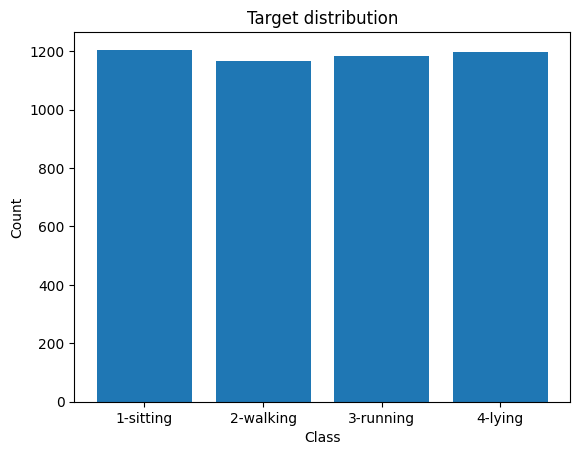

In [60]:
#eda
display(dataset_df.head(3))

#any missing
miss_pct = dataset_df.isna().mean().mul(100).sort_values(ascending=False).head(10)
display(miss_pct)

#variance of features
var_top = X.var().sort_values(ascending=False).head(10)
display(var_top)

#bar graph
plt.figure()
counts = y.value_counts().sort_index()
plt.bar(['1-sitting', '2-walking', '3-running', '4-lying'], counts.values)
plt.title("Target distribution"); plt.xlabel("Class"); plt.ylabel("Count")
plt.show()

In [ ]:
#split into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, stratify=y, random_state=RANDOM_STATE
)


print("[INFO] Train: ", X_train.shape),
print("Test: ", X_test.shape)
print("[INFO] Train class counts:\n", y_train.value_counts())
print("[INFO] Test  class counts:\n", y_test.value_counts())

[INFO] Train:  (3800, 37)
Test:  (951, 37)
[INFO] Train class counts:
 activity_id
1    964
4    956
3    947
2    933
Name: count, dtype: int64
[INFO] Test  class counts:
 activity_id
1    241
4    240
3    237
2    233
Name: count, dtype: int64


In [62]:
#pipeline
def build_pipeline(scaler, n_neighbors=5, metric="euclidean", weights="uniform"):
    steps = [("imputer", SimpleImputer(strategy="median"))]
    if scaler is not None:
        steps.append(("scaler", scaler))
    steps.append(("knn", KNeighborsClassifier(n_neighbors=n_neighbors, metric=metric, weights=weights)))
    return Pipeline(steps)

#stratified-k-fold
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
#group-k-fold
gkf = GroupKFold(n_splits=5)
#stratified-group-k-fold
sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

In [63]:
#parameters for diff combinations of neigbhours, metric and weight
param_grid = {
    'knn__n_neighbors': [3, 5, 7],
    'knn__metric': ['euclidean', 'manhattan'],
    'knn__weights': ['uniform', 'distance']
}

MINMAX SCALER

In [64]:
#best parameters and accuracy with MinMax Scaler
pipe_minnax = build_pipeline(MinMaxScaler())
grid_minmax = GridSearchCV(pipe_minnax, param_grid, cv=gkf, scoring='accuracy', n_jobs=-1)
grid_minmax.fit(X, y, groups=groups)

#print all the models
search_cvs_minmax = pd.DataFrame(grid_minmax.cv_results_)
for i, row in search_cvs_minmax.iterrows():
    print(f"Params: {row['params']}, Mean CV Accuracy: {row['mean_test_score']:.4f}, Std: {row['std_test_score']:.4f}")

print("Best Parameters:", grid_minmax.best_params_)
print("Best Accuracy:", grid_minmax.best_score_)

best_model_minmax = grid_minmax.best_estimator_

Params: {'knn__metric': 'euclidean', 'knn__n_neighbors': 3, 'knn__weights': 'uniform'}, Mean CV Accuracy: 0.9435, Std: 0.0970
Params: {'knn__metric': 'euclidean', 'knn__n_neighbors': 3, 'knn__weights': 'distance'}, Mean CV Accuracy: 0.9435, Std: 0.0970
Params: {'knn__metric': 'euclidean', 'knn__n_neighbors': 5, 'knn__weights': 'uniform'}, Mean CV Accuracy: 0.9443, Std: 0.0974
Params: {'knn__metric': 'euclidean', 'knn__n_neighbors': 5, 'knn__weights': 'distance'}, Mean CV Accuracy: 0.9443, Std: 0.0974
Params: {'knn__metric': 'euclidean', 'knn__n_neighbors': 7, 'knn__weights': 'uniform'}, Mean CV Accuracy: 0.9439, Std: 0.0972
Params: {'knn__metric': 'euclidean', 'knn__n_neighbors': 7, 'knn__weights': 'distance'}, Mean CV Accuracy: 0.9439, Std: 0.0972
Params: {'knn__metric': 'manhattan', 'knn__n_neighbors': 3, 'knn__weights': 'uniform'}, Mean CV Accuracy: 0.9947, Std: 0.0072
Params: {'knn__metric': 'manhattan', 'knn__n_neighbors': 3, 'knn__weights': 'distance'}, Mean CV Accuracy: 0.9947, 

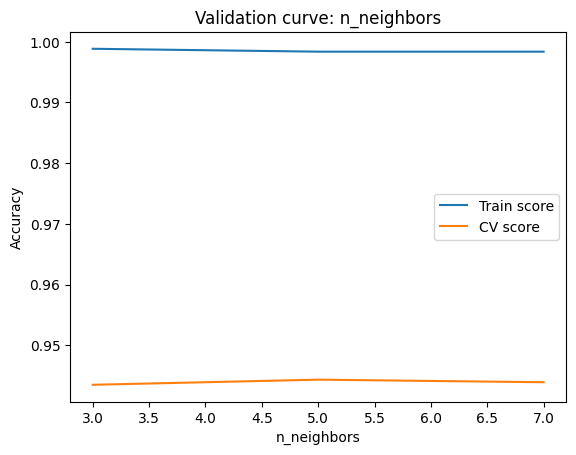

In [65]:
#try validation curve with n_neighbor
param_range = [3,5,7]
train_scores, test_scores = validation_curve(
    pipe_minnax, X, y, param_name="knn__n_neighbors", param_range=param_range,
    cv=gkf.split(X, y, groups=groups), scoring="accuracy", n_jobs=-1
)


plt.plot(param_range, np.mean(train_scores, axis=1), label='Train score')
plt.plot(param_range, np.mean(test_scores, axis=1), label='CV score')
plt.xlabel("n_neighbors")
plt.ylabel("Accuracy")
plt.title("Validation curve: n_neighbors")
plt.legend()
plt.show()

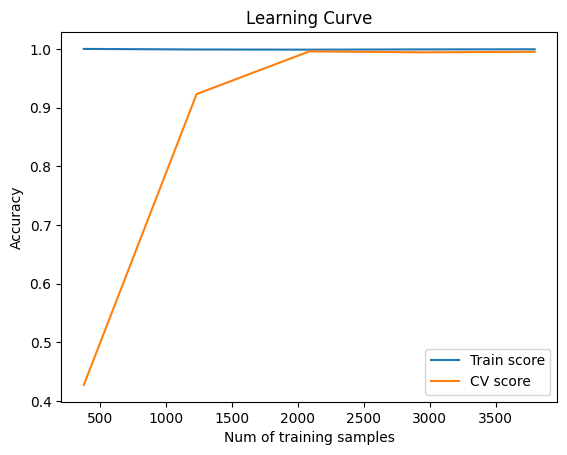

In [66]:
#learning curve
train_sizes, train_scores_lc, test_scores_lc = learning_curve(
    best_model_minmax, X, y, cv=gkf.split(X, y, groups=groups), train_sizes=np.linspace(0.1,1.0,5),
    scoring='accuracy', n_jobs=-1
)


plt.plot(train_sizes, np.mean(train_scores_lc, axis=1), label='Train score')
plt.plot(train_sizes, np.mean(test_scores_lc, axis=1), label='CV score')
plt.xlabel("Num of training samples")
plt.ylabel("Accuracy")
plt.title("Learning Curve")
plt.legend()
plt.show()

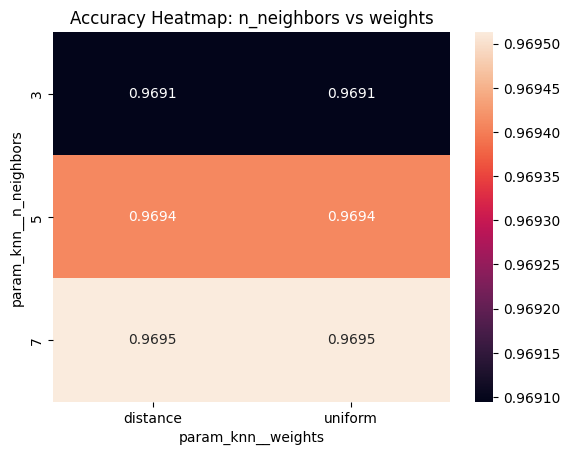

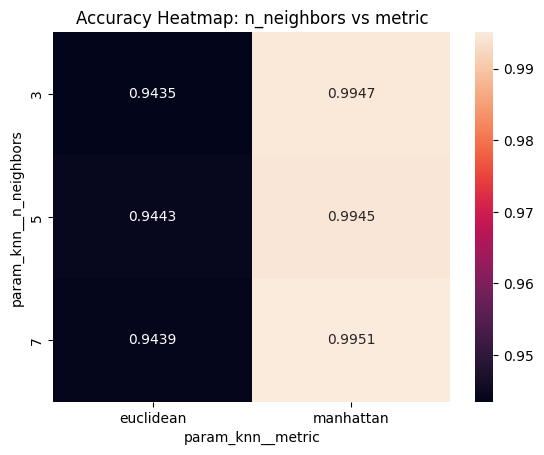

In [67]:
#hyper-parameter heatmap (n_neighbors vs weights)
heatmap_data = search_cvs_minmax.pivot_table(
    values='mean_test_score', 
    index='param_knn__n_neighbors', 
    columns='param_knn__weights'
)

sns.heatmap(heatmap_data, annot=True, fmt=".4f")
plt.title("Accuracy Heatmap: n_neighbors vs weights")
plt.show()


#hyper-parameter heatmap (n_neighbors vs metric)
heatmap_data = search_cvs_minmax.pivot_table(
    values='mean_test_score', 
    index='param_knn__n_neighbors', 
    columns='param_knn__metric'
)

sns.heatmap(heatmap_data, annot=True, fmt=".4f")
plt.title("Accuracy Heatmap: n_neighbors vs metric")
plt.show()

Test Accuracy: 1.0
Classification Report: 
               precision    recall  f1-score   support

           1       1.00      1.00      1.00       241
           2       1.00      1.00      1.00       233
           3       1.00      1.00      1.00       237
           4       1.00      1.00      1.00       240

    accuracy                           1.00       951
   macro avg       1.00      1.00      1.00       951
weighted avg       1.00      1.00      1.00       951

Test F1: [1. 1. 1. 1.]


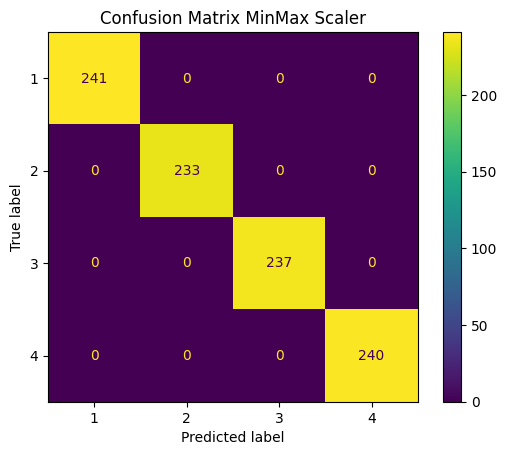

In [68]:
#Model Evaluation

#test predict
y_pred_minmax = best_model_minmax.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, y_pred_minmax))
print("Classification Report: \n", classification_report(y_test, y_pred_minmax))

#f1 test
f1_test = precision_recall_fscore_support(y_test, y_pred_minmax, average=None, zero_division=0)[2]
print("Test F1:", f1_test)

#confusion matrix
cm_minmax = confusion_matrix(y_test, y_pred_minmax)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_minmax, display_labels=best_model_minmax.named_steps['knn'].classes_)
disp.plot()
plt.title("Confusion Matrix MinMax Scaler")
plt.show()

<Figure size 800x600 with 0 Axes>

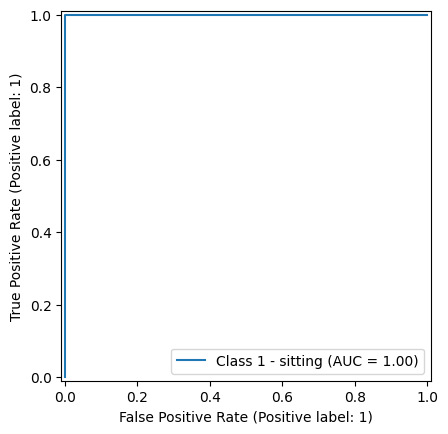

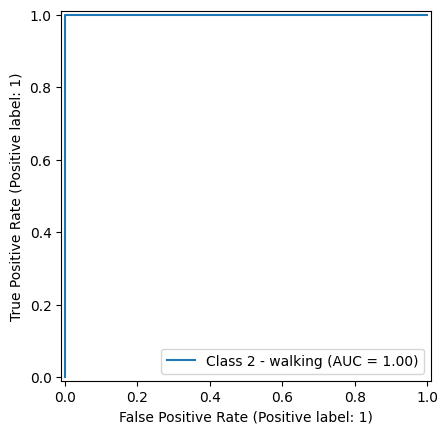

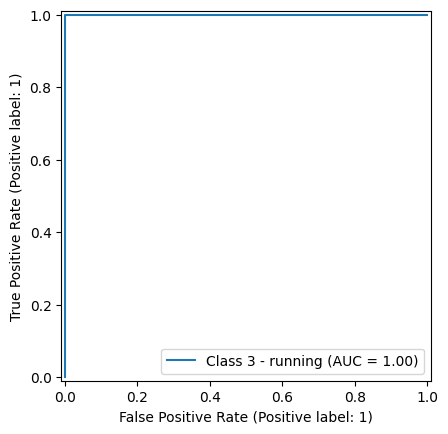

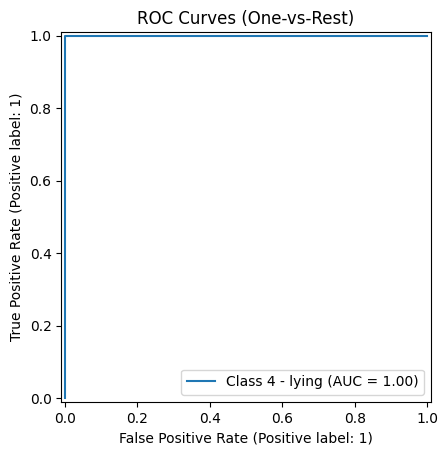

<Figure size 800x600 with 0 Axes>

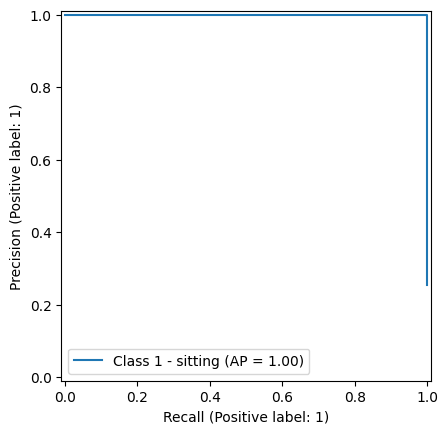

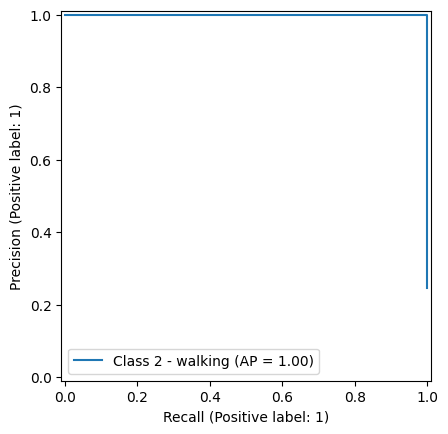

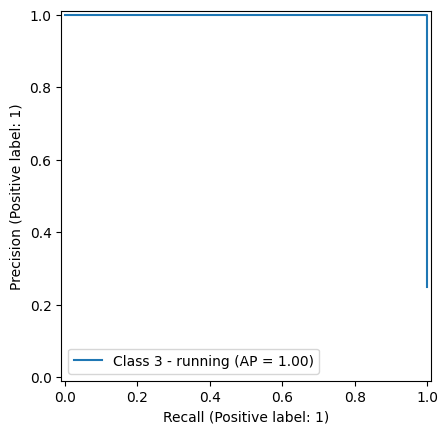

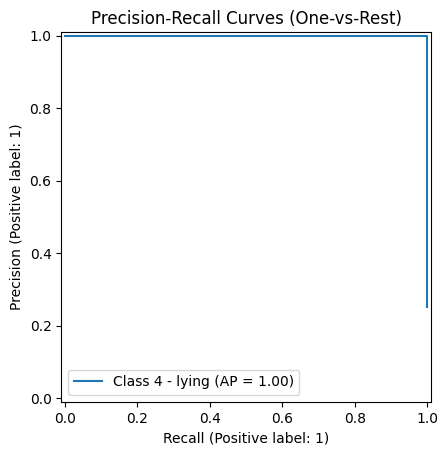

In [69]:
#ROC & PR curves (multiclass)
from sklearn.preprocessing import label_binarize
classes = best_model_minmax.named_steps['knn'].classes_
y_test_bin = label_binarize(y_test, classes=classes)
y_prob = best_model_minmax.predict_proba(X_test)


#ROC for each class
plt.figure(figsize=(8,6))
for i, class_label in enumerate(classes):
    label = ""
    if class_label == 1:
        label = '1 - sitting'
    elif class_label == 2:
        label = '2 - walking'
    elif class_label == 3:
        label = '3 - running'
    elif class_label == 4:
        label = '4 - lying'
    else:
        label = class_label
    RocCurveDisplay.from_predictions(y_test_bin[:, i], y_prob[:, i], name=f"Class {label}")
plt.title("ROC Curves (One-vs-Rest)")
plt.show()

print("===========================================\n")

#precision-recall fro each class
plt.figure(figsize=(8,6))
for i, class_label in enumerate(classes):
    label = ""
    if class_label == 1:
        label = '1 - sitting'
    elif class_label == 2:
        label = '2 - walking'
    elif class_label == 3:
        label = '3 - running'
    elif class_label == 4:
        label = '4 - lying'
    else:
        label = class_label
    PrecisionRecallDisplay.from_predictions(y_test_bin[:, i], y_prob[:, i], name=f"Class {label}")
plt.title("Precision-Recall Curves (One-vs-Rest)")
plt.show()

/Users/laura/VSCodeProj/ML_project/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


Shape: (951, 7)
Min distance: 9.507412162135394
Max distance: 80.65038070999594
Mean distance: 34.76222681216733
Median distance: 30.440893908865203
Standard deviation of distances: 21.27133181857308


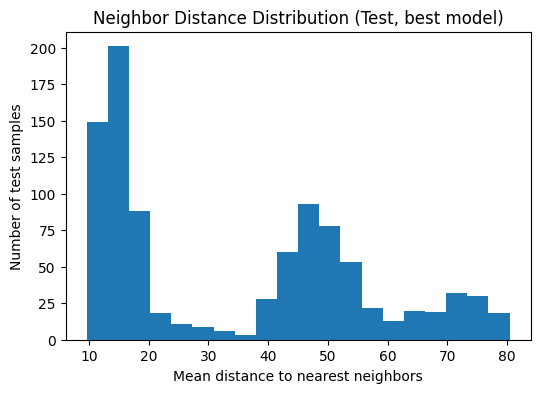

In [70]:
#neighbor distance distribution
#array of distances, each test sample to its knn
distances, indices = best_model_minmax.named_steps['knn'].kneighbors(X_test)
mean_dist_minmax = distances.mean(axis=1)

#shape of distances, (num test_samples, n_neighbors)
print("Shape:", distances.shape)

#info details
print("Min distance:", distances.min())
print("Max distance:", distances.max())
print("Mean distance:", distances.mean())
print("Median distance:", np.median(distances))
print("Standard deviation of distances:", distances.std())

#histogram distrib
plt.figure(figsize=(6,4))
plt.hist(mean_dist_minmax, bins=20)
plt.xlabel("Mean distance to nearest neighbors")
plt.ylabel("Number of test samples")
plt.title("Neighbor Distance Distribution (Test, best model)")
plt.show()

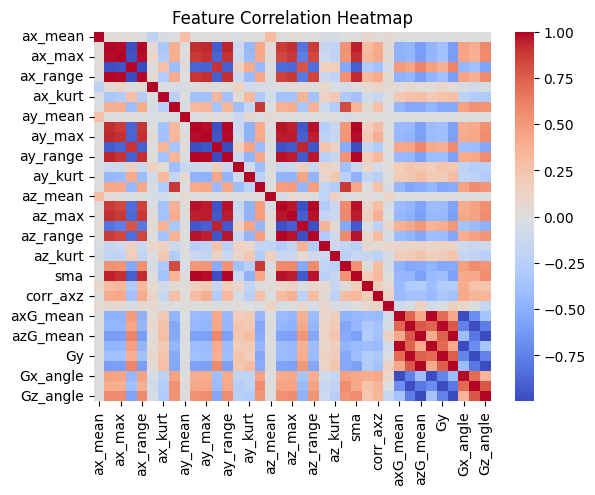

In [71]:
#feature correlation
sns.heatmap(X.corr(), cmap='coolwarm', center=0)
plt.title("Feature Correlation Heatmap")
plt.show()

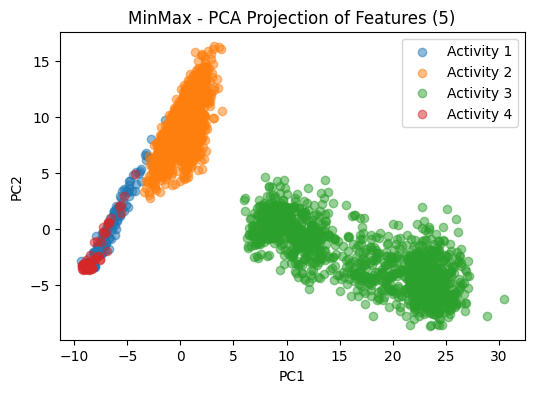

In [73]:
#visualize features separately
pca_minmax = PCA(n_components=5)
X_pca_minmax = pca_minmax.fit_transform(X)

plt.figure(figsize=(6,4))
for label in y.unique():
    plt.scatter(X_pca_minmax[y==label,0], X_pca_minmax[y==label,1], label=f'Activity {label}', alpha=0.5)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("MinMax - PCA Projection of Features (5)")
plt.legend()
plt.show()

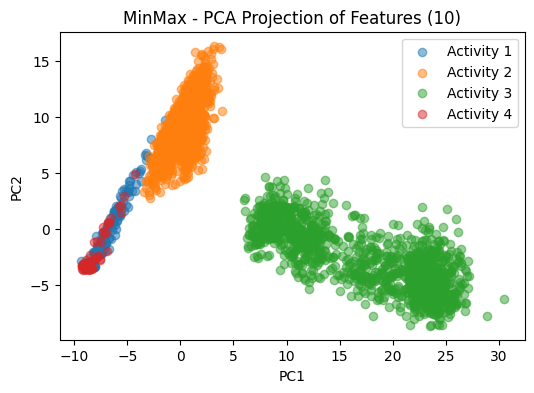

In [74]:
#visualize features separately
pca_minmax = PCA(n_components=10)
X_pca_minmax = pca_minmax.fit_transform(X)

plt.figure(figsize=(6,4))
for label in y.unique():
    plt.scatter(X_pca_minmax[y==label,0], X_pca_minmax[y==label,1], label=f'Activity {label}', alpha=0.5)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("MinMax - PCA Projection of Features (10)")
plt.legend()
plt.show()

STANDARD SCALER

In [75]:
#best parameters and accuracy with Standard Scaler
pipe_standard = build_pipeline(StandardScaler())
grid_standard = GridSearchCV(pipe_standard, param_grid, cv=gkf, scoring='accuracy', n_jobs=-1, return_train_score=True)
grid_standard.fit(X, y, groups=groups)

#print all the models
search_cvs_standard = pd.DataFrame(grid_standard.cv_results_)
for i, row in search_cvs_standard.iterrows():
    print(f"Params: {row['params']}, Mean Test Score: {row['mean_test_score']:.4f}, Std Test Score: {row['std_test_score']:.4f}")

print("Best Parameters:", grid_standard.best_params_)
print("Best Accuracy:", grid_standard.best_score_)

best_model_standard = grid_standard.best_estimator_

Params: {'knn__metric': 'euclidean', 'knn__n_neighbors': 3, 'knn__weights': 'uniform'}, Mean Test Score: 0.9444, Std Test Score: 0.0971
Params: {'knn__metric': 'euclidean', 'knn__n_neighbors': 3, 'knn__weights': 'distance'}, Mean Test Score: 0.9444, Std Test Score: 0.0971
Params: {'knn__metric': 'euclidean', 'knn__n_neighbors': 5, 'knn__weights': 'uniform'}, Mean Test Score: 0.9450, Std Test Score: 0.0964
Params: {'knn__metric': 'euclidean', 'knn__n_neighbors': 5, 'knn__weights': 'distance'}, Mean Test Score: 0.9450, Std Test Score: 0.0964
Params: {'knn__metric': 'euclidean', 'knn__n_neighbors': 7, 'knn__weights': 'uniform'}, Mean Test Score: 0.9448, Std Test Score: 0.0968
Params: {'knn__metric': 'euclidean', 'knn__n_neighbors': 7, 'knn__weights': 'distance'}, Mean Test Score: 0.9448, Std Test Score: 0.0968
Params: {'knn__metric': 'manhattan', 'knn__n_neighbors': 3, 'knn__weights': 'uniform'}, Mean Test Score: 0.9807, Std Test Score: 0.0302
Params: {'knn__metric': 'manhattan', 'knn__n_

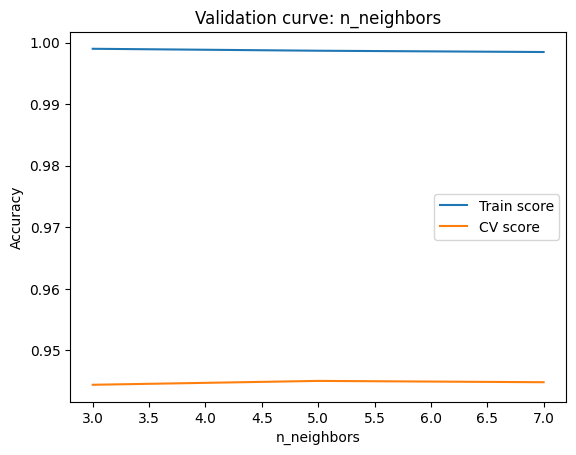

In [76]:
#try validation curve with n_neighbor
param_range = [3,5,7]
train_scores, test_scores = validation_curve(
    pipe_standard, X, y, param_name="knn__n_neighbors", param_range=param_range,
    cv=gkf.split(X, y, groups=groups), scoring="accuracy", n_jobs=-1
)


plt.plot(param_range, np.mean(train_scores, axis=1), label='Train score')
plt.plot(param_range, np.mean(test_scores, axis=1), label='CV score')
plt.xlabel("n_neighbors")
plt.ylabel("Accuracy")
plt.title("Validation curve: n_neighbors")
plt.legend()
plt.show()

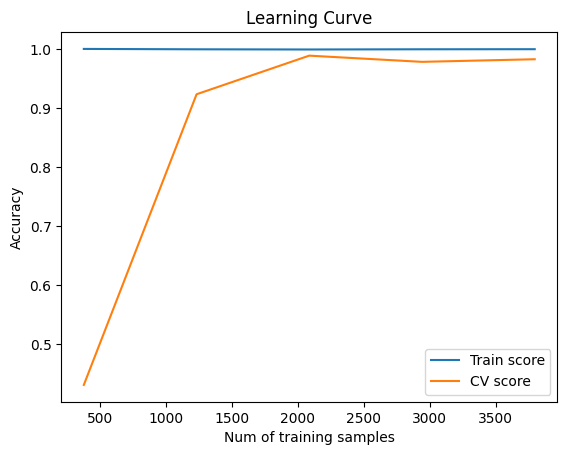

In [77]:
#learning curve
train_sizes, train_scores_lc, test_scores_lc = learning_curve(
    best_model_standard, X, y, cv=gkf.split(X, y, groups=groups), train_sizes=np.linspace(0.1,1.0,5),
    scoring='accuracy', n_jobs=-1
)


plt.plot(train_sizes, np.mean(train_scores_lc, axis=1), label='Train score')
plt.plot(train_sizes, np.mean(test_scores_lc, axis=1), label='CV score')
plt.xlabel("Num of training samples")
plt.ylabel("Accuracy")
plt.title("Learning Curve")
plt.legend()
plt.show()

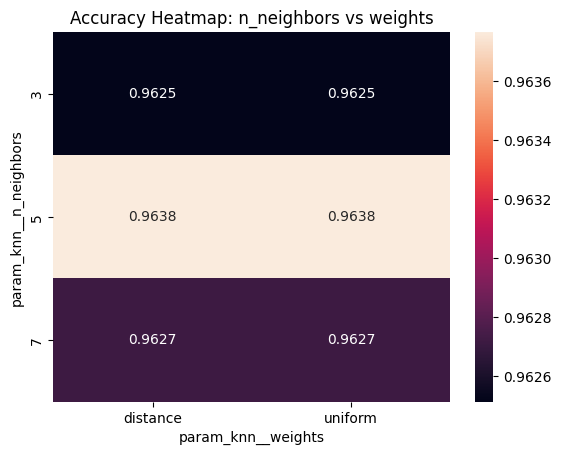

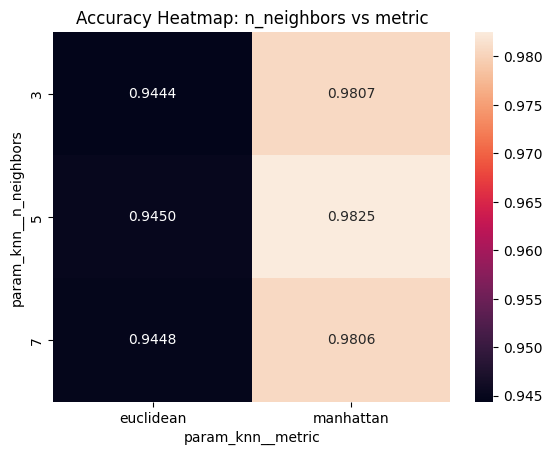

In [78]:
#hyper-parameter heatmap (n_neighbors vs weights)
heatmap_data = search_cvs_standard.pivot_table(
    values='mean_test_score', 
    index='param_knn__n_neighbors', 
    columns='param_knn__weights'
)

sns.heatmap(heatmap_data, annot=True, fmt=".4f")
plt.title("Accuracy Heatmap: n_neighbors vs weights")
plt.show()



#hyper-parameter heatmap (n_neighbors vs metric)
heatmap_data = search_cvs_standard.pivot_table(
    values='mean_test_score', 
    index='param_knn__n_neighbors', 
    columns='param_knn__metric'
)

sns.heatmap(heatmap_data, annot=True, fmt=".4f")
plt.title("Accuracy Heatmap: n_neighbors vs metric")
plt.show()

Test Accuracy: 1.0
Classification Report: 
               precision    recall  f1-score   support

           1       1.00      1.00      1.00       241
           2       1.00      1.00      1.00       233
           3       1.00      1.00      1.00       237
           4       1.00      1.00      1.00       240

    accuracy                           1.00       951
   macro avg       1.00      1.00      1.00       951
weighted avg       1.00      1.00      1.00       951

Test F1: [1. 1. 1. 1.]


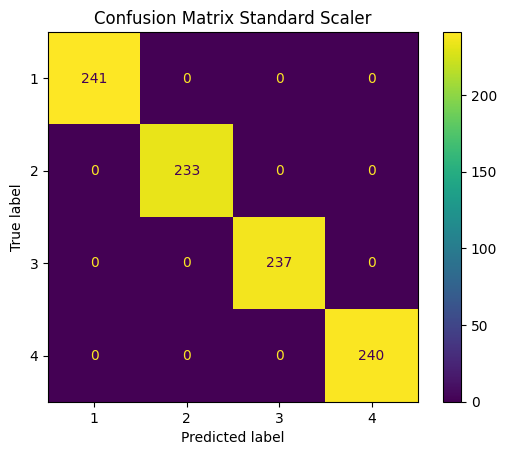

In [79]:
#Model Evaluation

#test predict
y_pred_std = best_model_standard.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, y_pred_std))
print("Classification Report: \n", classification_report(y_test, y_pred_std))

#f1 test
f1_test_std = precision_recall_fscore_support(y_test, y_pred_std, average=None, zero_division=0)[2]
print("Test F1:", f1_test_std)

#confusion matrix
cm_std = confusion_matrix(y_test, y_pred_std)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_std, display_labels=best_model_standard.named_steps['knn'].classes_)
disp.plot()
plt.title("Confusion Matrix Standard Scaler")
plt.show()

<Figure size 800x600 with 0 Axes>

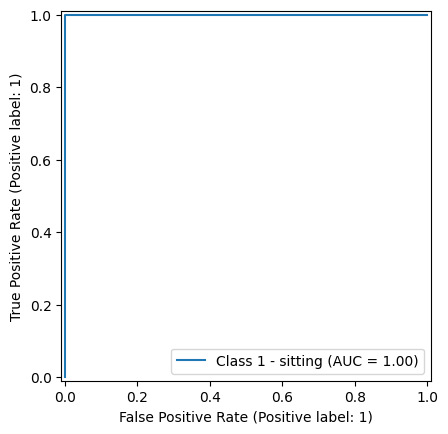

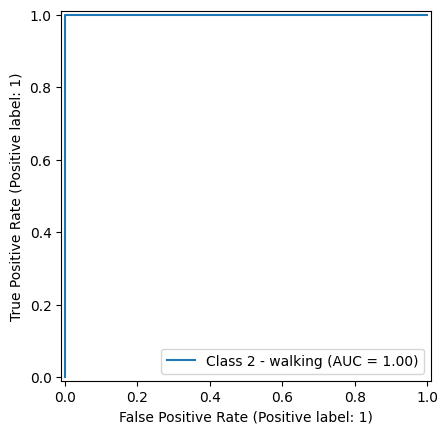

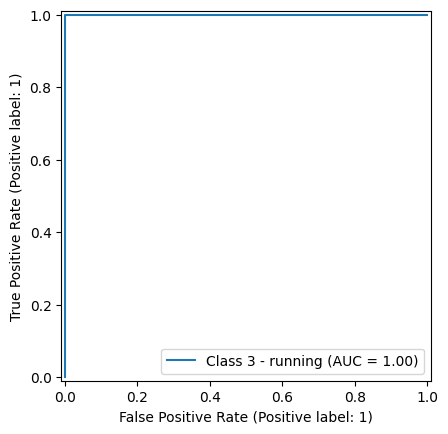

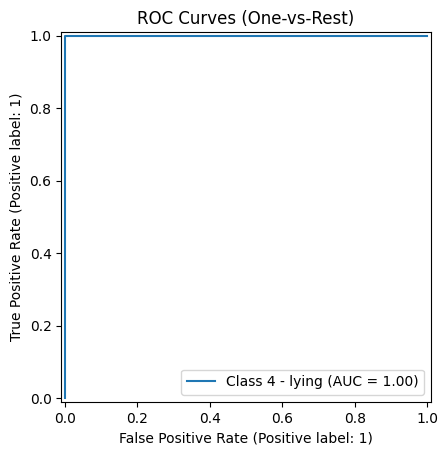

<Figure size 800x600 with 0 Axes>

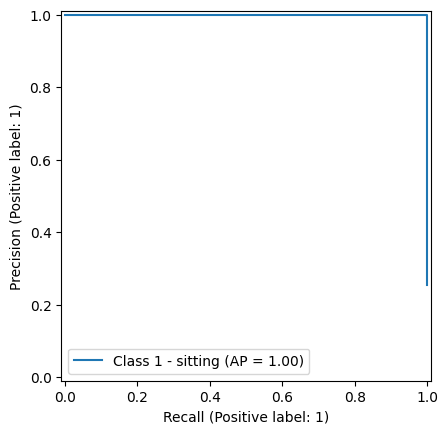

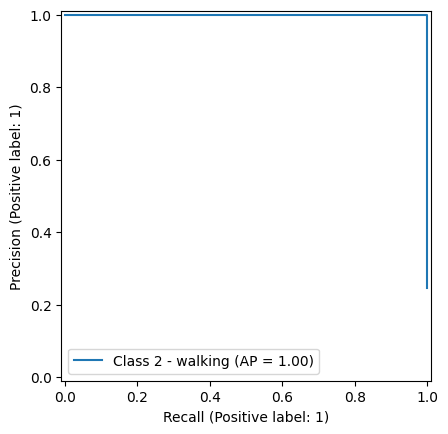

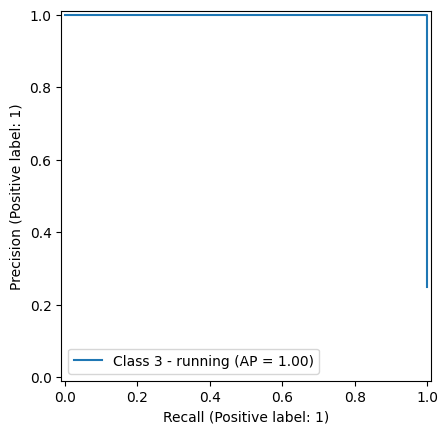

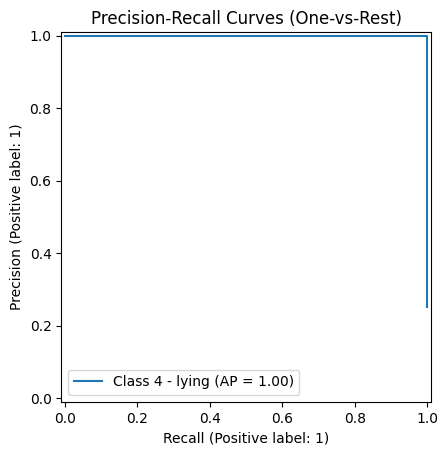

In [80]:
#ROC & PR curves (multiclass)
from sklearn.preprocessing import label_binarize
classes = best_model_standard.named_steps['knn'].classes_
y_test_bin_std = label_binarize(y_test, classes=classes)
y_prob_std = best_model_standard.predict_proba(X_test)


#ROC for each class
plt.figure(figsize=(8,6))
for i, class_label in enumerate(classes):
    label = ""
    if class_label == 1:
        label = '1 - sitting'
    elif class_label == 2:
        label = '2 - walking'
    elif class_label == 3:
        label = '3 - running'
    elif class_label == 4:
        label = '4 - lying'
    else:
        label = class_label
    RocCurveDisplay.from_predictions(y_test_bin_std[:, i], y_prob_std[:, i], name=f"Class {label}")
plt.title("ROC Curves (One-vs-Rest)")
plt.show()

print("===============================================\n")

#precision-recall fro each class
plt.figure(figsize=(8,6))
for i, class_label in enumerate(classes):
    label = ""
    if class_label == 1:
        label = '1 - sitting'
    elif class_label == 2:
        label = '2 - walking'
    elif class_label == 3:
        label = '3 - running'
    elif class_label == 4:
        label = '4 - lying'
    else:
        label = class_label
    PrecisionRecallDisplay.from_predictions(y_test_bin_std[:, i], y_prob_std[:, i], name=f"Class {label}")
plt.title("Precision-Recall Curves (One-vs-Rest)")
plt.show()

/Users/laura/VSCodeProj/ML_project/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


Shape: (951, 5)
Min distance: 14.521983990677004
Max distance: 73.1645317099
Mean distance: 33.05166893938314
Median distance: 27.043244125051537
Standard deviation of distances: 16.67857443368065


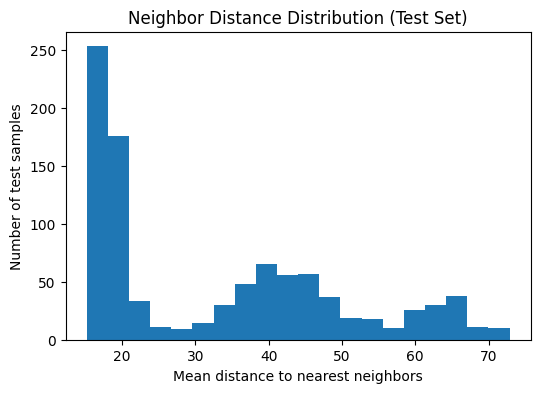

In [81]:
#neighbor distance distribution
#array of distances, each test sample to its knn
distances, indices = best_model_standard.named_steps['knn'].kneighbors(X_test)
mean_dist_std = distances.mean(axis=1)

#shape of distances, (num test_samples, n_neighbors)
print("Shape:", distances.shape)

#info details
print("Min distance:", distances.min())
print("Max distance:", distances.max())
print("Mean distance:", distances.mean())
print("Median distance:", np.median(distances))
print("Standard deviation of distances:", distances.std())

#histogram distrib
plt.figure(figsize=(6,4))
plt.hist(mean_dist_std, bins=20)
plt.xlabel("Mean distance to nearest neighbors")
plt.ylabel("Number of test samples")
plt.title("Neighbor Distance Distribution (Test Set)")
plt.show()

Best Params: {'knn__metric': 'manhattan', 'knn__n_neighbors': 7, 'knn__weights': 'uniform'}
Best Mean LOGO Accuracy: 0.995102

Evaluation=========================

Participant LL Accuracy: 0.979701
Classification Report: 
               precision    recall  f1-score   support

           1       1.00      0.92      0.96       239
           2       0.92      1.00      0.96       231
           3       1.00      1.00      1.00       237
           4       1.00      1.00      1.00       229

    accuracy                           0.98       936
   macro avg       0.98      0.98      0.98       936
weighted avg       0.98      0.98      0.98       936

Test F1: [0.95860566 0.96049896 1.         1.        ]


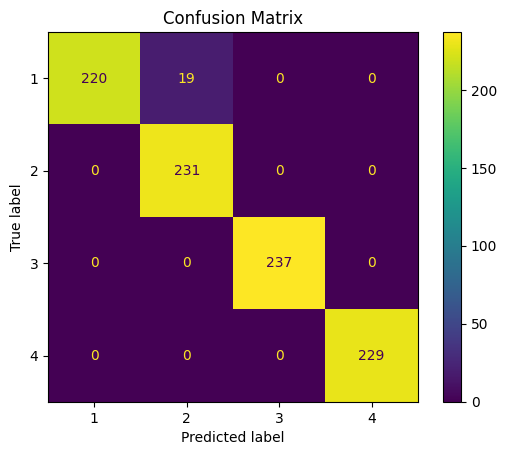

Participant VV Accuracy: 1.000000
Classification Report: 
               precision    recall  f1-score   support

           1       1.00      1.00      1.00       236
           2       1.00      1.00      1.00       235
           3       1.00      1.00      1.00       231
           4       1.00      1.00      1.00       248

    accuracy                           1.00       950
   macro avg       1.00      1.00      1.00       950
weighted avg       1.00      1.00      1.00       950

Test F1: [1. 1. 1. 1.]


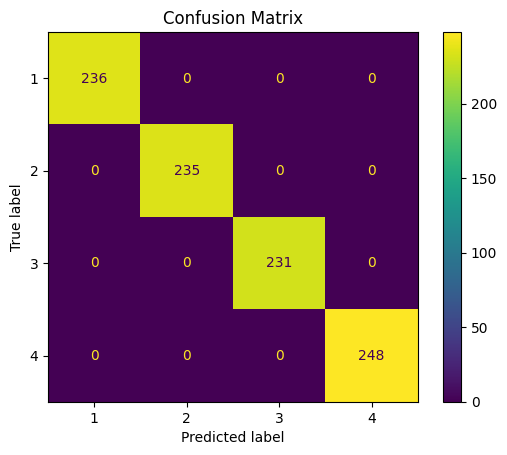

Participant YL Accuracy: 0.998955
Classification Report: 
               precision    recall  f1-score   support

           1       1.00      1.00      1.00       234
           2       1.00      1.00      1.00       234
           3       1.00      1.00      1.00       245
           4       1.00      1.00      1.00       244

    accuracy                           1.00       957
   macro avg       1.00      1.00      1.00       957
weighted avg       1.00      1.00      1.00       957

Test F1: [1.         0.9978678  0.99795501 1.        ]


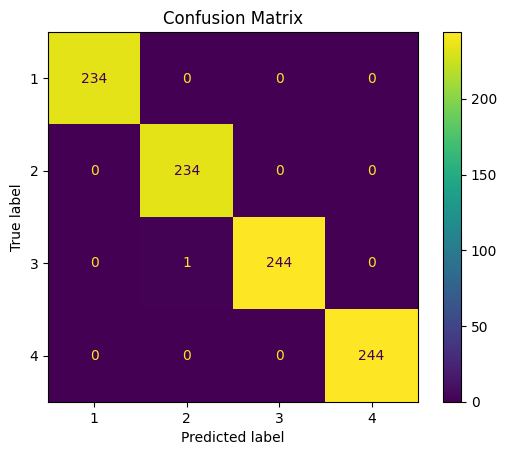

Participant YT Accuracy: 1.000000
Classification Report: 
               precision    recall  f1-score   support

           1       1.00      1.00      1.00       243
           2       1.00      1.00      1.00       237
           3       1.00      1.00      1.00       237
           4       1.00      1.00      1.00       237

    accuracy                           1.00       954
   macro avg       1.00      1.00      1.00       954
weighted avg       1.00      1.00      1.00       954

Test F1: [1. 1. 1. 1.]


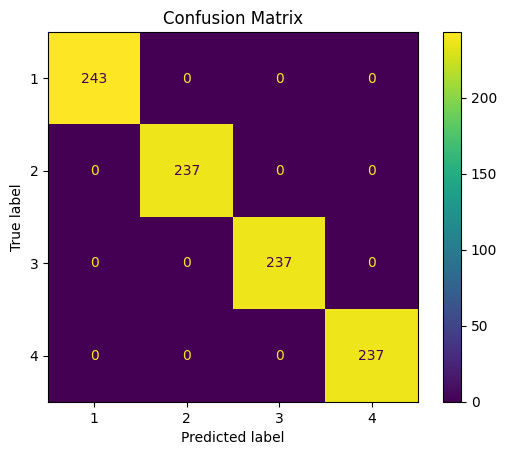

Participant ZM Accuracy: 0.996855
Classification Report: 
               precision    recall  f1-score   support

           1       0.99      1.00      0.99       253
           2       1.00      1.00      1.00       229
           3       1.00      1.00      1.00       234
           4       1.00      0.99      0.99       238

    accuracy                           1.00       954
   macro avg       1.00      1.00      1.00       954
weighted avg       1.00      1.00      1.00       954

Test F1: [0.99410609 1.         1.         0.99365751]


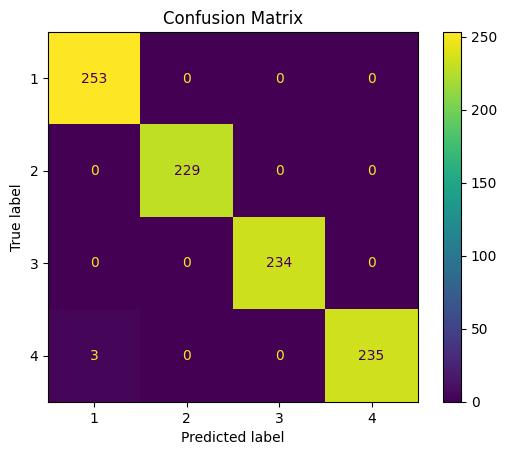


Mean LOGO Test Accuracy: 0.9951022537066778


In [82]:
#try one group out for test

from sklearn.model_selection import LeaveOneGroupOut

logo = LeaveOneGroupOut()

param_grid = {
    'knn__n_neighbors': [3, 5, 7],
    'knn__metric': ['euclidean', 'manhattan'],
    'knn__weights': ['uniform', 'distance']
}

pipe = build_pipeline(MinMaxScaler())

grid = GridSearchCV(
    pipe,
    param_grid,
    cv=logo,
    scoring='accuracy',
    n_jobs=-1
)

grid.fit(X, y, groups=groups)


print("Best Params:", grid.best_params_)
print(f"Best Mean LOGO Accuracy: {grid.best_score_:.6f}")


print("\nEvaluation=========================\n")

#evaluation
logo_scores = []

for train_idx, test_idx in logo.split(X, y, groups):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    model = grid.best_estimator_
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    participant = groups.iloc[test_idx].unique()[0]

    print(f"Participant {participant} Accuracy: {acc:.6f}")
    logo_scores.append(acc)
    
    print("Classification Report: \n", classification_report(y_test, y_pred))
    
    f1_test = precision_recall_fscore_support(y_test, y_pred, average=None, zero_division=0)[2]
    print("Test F1:", f1_test)
    
    #confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.named_steps['knn'].classes_)
    disp.plot()
    plt.title("Confusion Matrix")
    plt.show()

print("\nMean LOGO Test Accuracy:", np.mean(logo_scores))